In [3]:
import pandas as pd

df = pd.read_csv('/content/jena_climate_2009_2016.csv' , parse_dates = True, index_col='Date Time' )
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
Date Time,,,,,,,,,,,,,,
2009-01-01 00:10:00,996.52,-8.02,265.40,-8.90,93.30,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
2009-01-01 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2009-01-01 00:30:00,996.53,-8.51,264.91,-9.31,93.90,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
2009-01-01 00:40:00,996.51,-8.31,265.12,-9.07,94.20,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
2009-01-01 00:50:00,996.51,-8.27,265.15,-9.04,94.10,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
2016-12-31 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
2016-12-31 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2


In [4]:
header = list(df.columns.values)
header

['p (mbar)',
 'T (degC)',
 'Tpot (K)',
 'Tdew (degC)',
 'rh (%)',
 'VPmax (mbar)',
 'VPact (mbar)',
 'VPdef (mbar)',
 'sh (g/kg)',
 'H2OC (mmol/mol)',
 'rho (g/m**3)',
 'wv (m/s)',
 'max. wv (m/s)',
 'wd (deg)']

# Plotting the temperature timeseries

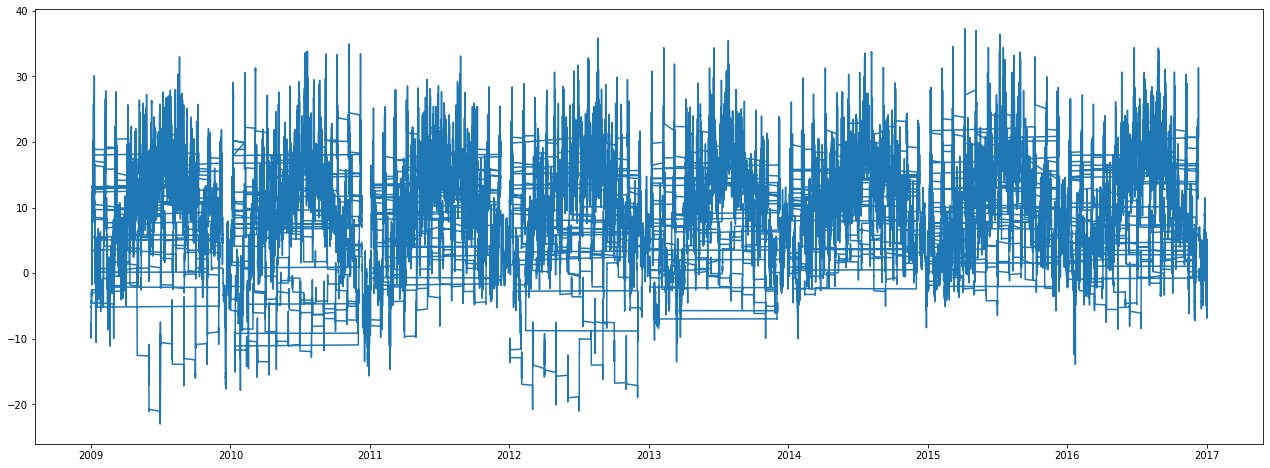

In [5]:
from matplotlib import pyplot as plt
plt.figure(figsize=(22, 8))
plt.plot( df['T (degC)'])

# Plotting the first 10 days of the temperature timeseries

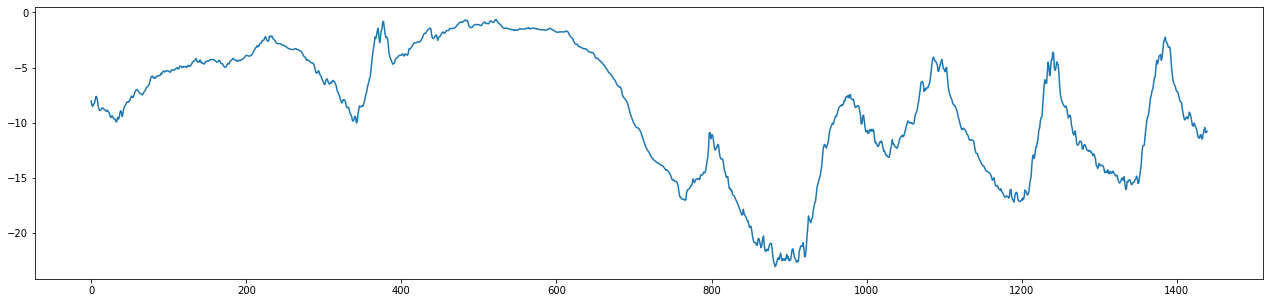

In [6]:
plt.figure(figsize=(22, 5))

plt.plot(range(1440) , df['T (degC)'].iloc[:1440])

# Parsing the data

In [7]:
# converting to numpy array
import numpy as np

float_data = np.zeros(df.shape)

for i in range(df.shape[0]):
  values = [float(x) for x in df.iloc[i, :]]
  float_data[i, :] = values

# Normalizing the data

You’re going to use the first 200,000 timesteps as training data,
so compute the mean and standard deviation only on this fraction of the data

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# Generator yielding timeseries samples and their targets

Because the samples in the dataset are highly redundant (sample N and
sample N + 1 will have most of their timesteps in common), it would be wasteful
to explicitly allocate every sample. Instead, you’ll generate the samples on the
fly using the original data.

In [9]:
def generator(data, lookback, delay, min_index, max_index,
  shuffle=False, batch_size=128, step=6):

  if max_index is None:
    max_index = len(data) - delay - 1
  
  i = min_index + lookback
  while True :
    if (shuffle) :
      rows = np.random.randint(
      min_index + lookback, max_index, size=batch_size)
    else:
      if (i + batch_size >= max_index) :
        i = min_index + lookback     # back to initial batch
      rows = np.arange(i, min(i + batch_size, max_index))
      i += len(rows)
  
    samples = np.zeros((len(rows),
                        lookback // step,
                        data.shape[-1]))
    
    targets = np.zeros((len(rows),))
    
    for j, row in enumerate(rows):
      indices = range(rows[j] - lookback, rows[j], step)
      samples[j] = data[indices]
      targets[j] = data[rows[j] + delay][1]
    yield samples, targets

In [10]:
lookback = 1440      # past 10 days
step = 6             # picking 1 observation every hour
delay = 144          # pridicting temp. distribution for next day
batch_size = 128     

In [11]:
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)

val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=300001,
                    max_index=None,
                    step=step,
                    batch_size=batch_size)

In [12]:
# we are not using last data_point in val_set/test_set 
# as it would be used by 2_nd last data_point for prediction

# How many steps to draw from
# val_gen in order to see the
# entire validation set
val_steps = (300000 - 200001 - lookback)

# How many steps to draw
# from test_gen in order to
# see the entire test set
test_steps = (len(float_data) - 300001 - lookback)

# A common-sense, non-machine-learning baseline

The temperature timeseries can safely be assumed to be continuous
(the temperatures tomorrow are likely to be close to the temperatures today) as well
as periodical with a daily period. Thus a common-sense approach is to always predict
that the temperature 24 hours from now will be equal to the temperature right now.

In [13]:
def evaluate_naive_method():
  batch_maes = []
  for step in range(val_steps):
    samples, targets = next(val_gen)
    preds = samples[:, -1, 1]   # taking last day of look_back 
    mae = np.mean(np.abs(preds - targets))
    batch_maes.append(mae)
  print(np.mean(batch_maes))

evaluate_naive_method()

0.28969941979609765


In [14]:
celsius_mae = 0.29 * std[1]
print(celsius_mae , ' degree_C')

2.5672247338393395  degree_C


# Training and evaluating a dropout-regularized (stacked)GRU-based model

In [ ]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
          dropout=0.2,
          recurrent_dropout=0.2,
          return_sequences=True,
          input_shape=(None, float_data.shape[-1])))

model.add(layers.GRU(64, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.5))

model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

# Plotting the Results

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()